<a href="https://colab.research.google.com/github/JEEF2601/Validation_the_Mex_ID_INE_with_OCR_using_Tesseract/blob/main/P3_Texto%20y%20datos%20secuenciales/_2_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Word2vec

word2vec no es un algoritmo singular, sino una familia de arquitecturas modelo y optimizaciones que se pueden usar para aprender incrustaciones de palabras a partir de grandes conjuntos de datos. Las incrustaciones aprendidas a través de word2vec han demostrado ser exitosas en una variedad de tareas de procesamiento de lenguaje natural posteriores.

**Nota: Este tutorial se basa en [Estimación eficiente de representaciones de palabras en espacio vectorial](https://arxiv.org/pdf/1301.3781.pdf) y [Representaciones distribuidas de palabras y frases y su composicionalidad](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) . No es una implementación exacta de los documentos. Más bien, pretende ilustrar las ideas clave.**

Estos artículos propusieron dos métodos para aprender las representaciones de las palabras:

*    Modelo continuo de bolsa de palabras : predice la palabra del medio en función de las palabras del contexto circundante. El contexto consta de unas pocas palabras antes y después de la palabra actual (en el medio). Esta arquitectura se denomina modelo de bolsa de palabras, ya que el orden de las palabras en el contexto no es importante.
*    Modelo de salto de gramo continuo : predice palabras dentro de un cierto rango antes y después de la palabra actual en la misma oración. Un ejemplo trabajado de esto se da a continuación.

En este tutorial, usará el método skip-gram. Primero, explorará skip-grams y otros conceptos usando una sola oración como ilustración. A continuación, entrenará su propio modelo word2vec en un pequeño conjunto de datos. Este tutorial también contiene código para exportar las incrustaciones entrenadas y visualizarlas en [TensorFlow Embedding Projector](http://projector.tensorflow.org/?hl=es-419&_gl=1*17n4vou*_ga*MTAxMTI5NDAwMC4xNjg2MDczMzk0*_ga_W0YLR4190T*MTY4NjA5NDIyNi4zLjEuMTY4NjA5NTUwMi4wLjAuMA..) .

## 1. Skip-gram y muestreo negativo

Mientras que un modelo de bolsa de palabras predice una palabra dado el contexto vecino, un modelo skip-gram predice el contexto (o vecinos) de una palabra, dada la palabra misma. El modelo está entrenado en skip-grams, que son n-grams que permiten omitir tokens (vea el diagrama a continuación para ver un ejemplo). El contexto de una palabra se puede representar a través de un conjunto de pares de omisión de gramo (`target_word`, `context_word`) donde `context_word` aparece en el contexto vecino de `target_word` .

Considere la siguiente oración de ocho palabras:

```
El ancho camino brillaba bajo el sol abrasador.
```



Las palabras de contexto para cada una de las 8 palabras de esta oración están definidas por un tamaño de ventana. El tamaño de la ventana determina el intervalo de palabras a ambos lados de `target_word` que puede considerarse una `context word` . A continuación se muestra una tabla de saltos de gramo para las palabras de destino en función de diferentes tamaños de ventana.

**Nota: Para este tutorial, un tamaño de ventana de n implica n palabras en cada lado con un espacio de ventana total de 2*n+1 palabras en una palabra.**

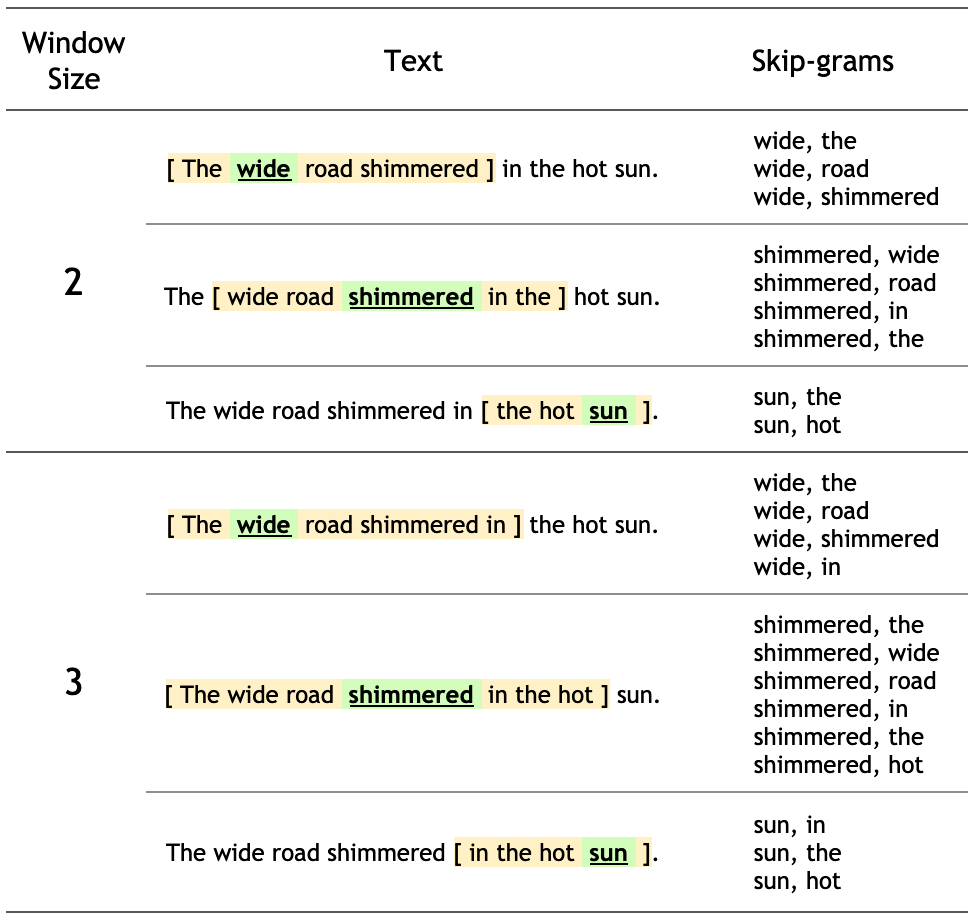

El objetivo de entrenamiento del modelo skip-gram es maximizar la probabilidad de predecir palabras de contexto dada la palabra objetivo. Para una secuencia de palabras w 1 , w 2 , ... w T , el objetivo se puede escribir como la probabilidad logarítmica promedio

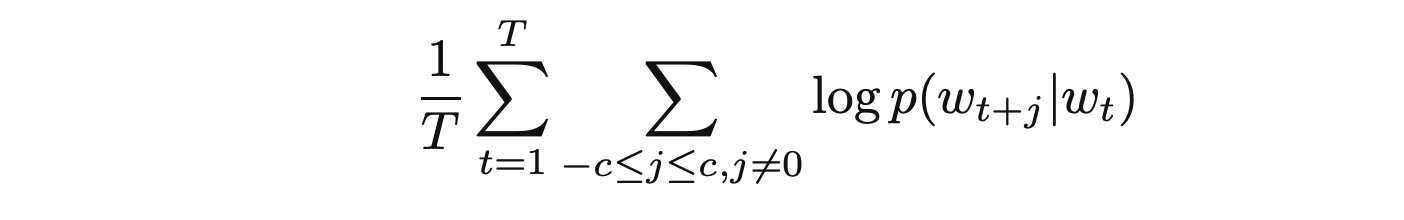

donde `c` es el tamaño del contexto de entrenamiento. La formulación básica de skip-gram define esta probabilidad usando la función softmax.

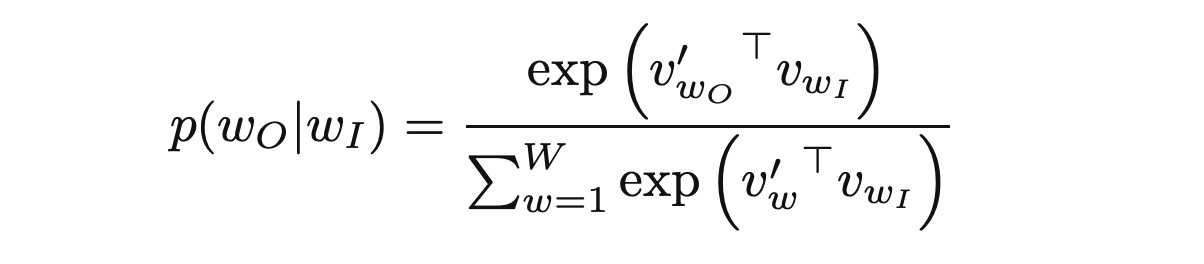

donde v y v ' son representaciones de vector objetivo y de contexto de palabras y W es el tamaño del vocabulario.

Calcular el denominador de esta formulación implica realizar un softmax completo sobre todas las palabras del vocabulario, que a menudo son términos grandes ($10^5 -10^7 $).

La función de pérdida de [estimación contrastiva de ruido](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss?hl=es-419) (NCE) es una aproximación eficiente para un softmax completo. Con el objetivo de aprender incrustaciones de palabras en lugar de modelar la distribución de palabras, la pérdida de NCE se puede [simplificar](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) para usar un muestreo negativo.

El objetivo de muestreo negativo simplificado para una palabra objetivo es distinguir la palabra de contexto de `num_ns` muestras negativas extraídas de la distribución de ruido $ _{Pn} (w)$ de palabras. Más precisamente, una aproximación eficiente de softmax completo sobre el vocabulario es, para un par de saltos de gramo, plantear la pérdida de una palabra objetivo como un problema de clasificación entre la palabra de contexto y `num_ns` muestras negativas.

Una muestra negativa se define como un `(target_word, context_word)` tal que `context_word` no aparece en la vecindad `window_size` de `target_word` . Para la oración de ejemplo, estas son algunas muestras negativas potenciales (cuando `window_size` es `2` ).



```
(hot, shimmered)
(wide, hot)
(wide, sun)
```



En la siguiente sección, generará skip-grams y muestras negativas para una sola oración. También aprenderá sobre técnicas de submuestreo y entrenará un modelo de clasificación para ejemplos de entrenamiento positivos y negativos más adelante en el tutorial.

## 2. Configuracion

### 2.0 Importaciones

In [1]:
import io
import re
import string
#Investigar tqdm
import tqdm
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Load the TensorBoard notebook extesion
%load_ext tensorboard

In [3]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

### 2.1 Vectorizar una oracion de ejemplo

Considere la siguiente oracion:


```
El ancho camino brillaba bajo el sol abrasador.
```

Tokenizar la oracion:




In [4]:
sentence = 'The wide road shimmered in the hot sun'
tokens = list(sentence.lower().split())
print(len(tokens))

8


Cree un vocabulario para guardar asiganaciones de tokens a indices enteros:

In [5]:
vocab,index = {},1 # start indexing from 1
vocab['<pad>'] = 0 # add a padding token

for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1

vocab_size = len(vocab)
print(vocab)

{'<pad>': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}


Cree un vocabulario inverso para guardar asignaciones de índices enteros a tokens:

In [6]:
inverse_vocab = {index: token  for token, index in vocab.items()}
print(inverse_vocab)

{0: '<pad>', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


Vectoriza tu oración:

In [7]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 1, 6, 7]


### 2.2 Genera saltos de gramo a partir de una oración

El módulo [`tf.keras.preprocessing.sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence?hl=es-419) proporciona funciones útiles que simplifican la preparación de datos para word2vec. Puede usar [`tf.keras.preprocessing.sequence.skipgrams`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams?hl=es-419) para generar pares de saltos de gramo a partir de `example_sequence` con un `window_size` dado a partir de tokens en el rango `[0, vocab_size)` .

**Nota: las muestras negative_samples se establecen en 0 aquí, ya que el procesamiento por lotes de muestras negativas generadas por esta función requiere un poco de código. Utilizará otra función para realizar un muestreo negativo en la siguiente sección.**

In [18]:
from keras.api._v2.keras import preprocessing
window_size = 2
positive_skip_gram, _ = tf.keras.preprocessing.sequence.skipgrams(
    example_sequence,
    vocabulary_size= vocab_size,
    window_size= window_size,
    negative_samples=0
)

print(len(positive_skip_gram))

26


Imprime algunos skip-grams positivos:

In [19]:
for target, context in positive_skip_gram[:5]:
  print(f"({target},{context}): ({inverse_vocab[target]},{inverse_vocab[context]})")

(5,4): (in,shimmered)
(2,3): (wide,road)
(3,2): (road,wide)
(7,1): (sun,the)
(5,3): (in,road)


### 2.3 Muestreo negativo para un skip-gram

La función `skipgrams` devuelve todos los pares skip-gram positivos deslizándose sobre un intervalo de ventana determinado. Para producir pares de saltos de gramo adicionales que sirvan como muestras negativas para el entrenamiento, debe muestrear palabras aleatorias del vocabulario. Utilice la función[ `tf.random.log_uniform_candidate_sampler`](https://www.tensorflow.org/api_docs/python/tf/random/log_uniform_candidate_sampler?hl=es-419) para muestrear `num_ns` de muestras negativas para una palabra de destino determinada en una ventana. Puede llamar a la función en la palabra de destino de un skip-grams y pasar la palabra de contexto como clase verdadera para excluirla de la muestra.

**Punto clave: num_ns (la cantidad de muestras negativas por palabra de contexto positivo) en el rango [5, 20] [funciona](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) mejor para conjuntos de datos más pequeños, mientras que num_ns en el rango [2, 5] es suficiente para conjuntos de datos más grandes.**

In [20]:
# Get target and context words for one positive skip-gram.
# (Positive skip-grams are the relationships that we want our model to learn.)
# (Context words are the words that we use to try to predict the target words.)

# Obtenemos las palabras objetivo y de contexto para un skip-gram positivo.
# (Los skip-grams positivos son las relaciones que queremos que nuestro modelo aprenda.)
# (Las palabras de contexto son las palabras que usamos para intentar predecir las palabras objetivo.)
target_word, context_word = positive_skip_gram[0]

# Set the number of negative samples per positive context.
# (How many incorrect answers to generate per correct answer.)

# Establecer el número de muestras negativas por contexto positivo.
# (Cuántas respuestas incorrectas generar por respuesta correcta.)
num_ns = 4

context_class = tf.reshape(tf.constant(context_word,dtype = "int64"),(1,1))
negative_sampling_candidates, _,_ = tf.random.log_uniform_candidate_sampler(
    true_classes = context_class,
    # class that should be sampled as "positive"
    # clase que debe muestrearse como "positiva"
    num_true = 1,
    # each  positive skip-gram has 1 positive context class
    # cada skip-grama positivo tiene 1 clase de contexto positivo
    num_sampled = num_ns,
    # number of negative context words to sample
    # número de palabras de contexto negativas para muestrear
    unique = True,
    # all the negative samples should be unique
    # todas las muestras negativas deben ser únicas
    range_max = vocab_size,
    # pick index of the samples from [0, vocab_size]
    # elija el índice de las muestras de [0, vocab_size]
    seed=SEED,
    # seed for reproducibility
    # semilla para reproducibilidad
    name = "negative_sampling"
    # name of this opteration
    # nombre de esta operación
)

print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
['<pad>', 'the', 'wide', 'road']


### 2.4 Construya un ejemplo de entrenamiento

Para un skip-gram positivo dado `(target_word, context_word)` , ahora también tiene `num_ns` palabras de contexto muestreadas negativas que no aparecen en la vecindad del tamaño de la ventana de `target_word` . Reúna `1` `context_word` positiva y num_ns palabras de contexto negativas en un tensor. Esto produce un conjunto de skip-grams positivos (etiquetados como `1` ) y muestras negativas (etiquetadas como `0` ) para cada palabra objetivo.

In [21]:
# add a dimension so you can use concatenation (in the next step).
# agrega una dimensión para que puedas usar la concatenación (en el siguiente paso).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates,1)

# Concat positive context word with negative sampled words.
# Concatena la palabra de contexto positiva con las palabras muestreadas negativas.
context = tf.concat([context_class, negative_sampling_candidates], 0)

# Label the first context word as "1" (positive) followed by num_ns "0"s (geative).
# Etiqueta la primera palabra de contexto como "1" (positiva) seguida de num_ns "0" (negativa).
label = tf.constant([1]+[0]*num_ns,dtype = "int64")

# Reshape the target to shape (1,) and context and label to "(num_ns + 1,)".
# Reshape el objetivo a la forma (1,) y el contexto y la etiqueta a "(num_ns + 1,)".
target  = tf.squeeze(target_word)
context = tf.squeeze(context)
label   = tf.squeeze(label)




Consulte el contexto y las etiquetas correspondientes para la palabra de destino del ejemplo de salto de gramo anterior:

In [22]:
print(f"Target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

Target_index    : 5
target_word     : in
context_indices : [4 0 1 2 3]
context_words   : ['shimmered', '<pad>', 'the', 'wide', 'road']
label           : [1 0 0 0 0]


Una tupla de tensores `(target, context, label)` constituye un ejemplo de entrenamiento para entrenar su modelo word2vec de muestreo negativo skip-gram. Observe que el destino tiene forma `(1,)` mientras que el contexto y la etiqueta tienen forma `(1+num_ns,)` .

In [23]:
print("target  :", target)
print("context :", context)
print("label   :", label)

target  : tf.Tensor(5, shape=(), dtype=int32)
context : tf.Tensor([4 0 1 2 3], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


### 2.5 Resumen

Este diagrama resume el procedimiento para generar un ejemplo de entrenamiento a partir de una oración:

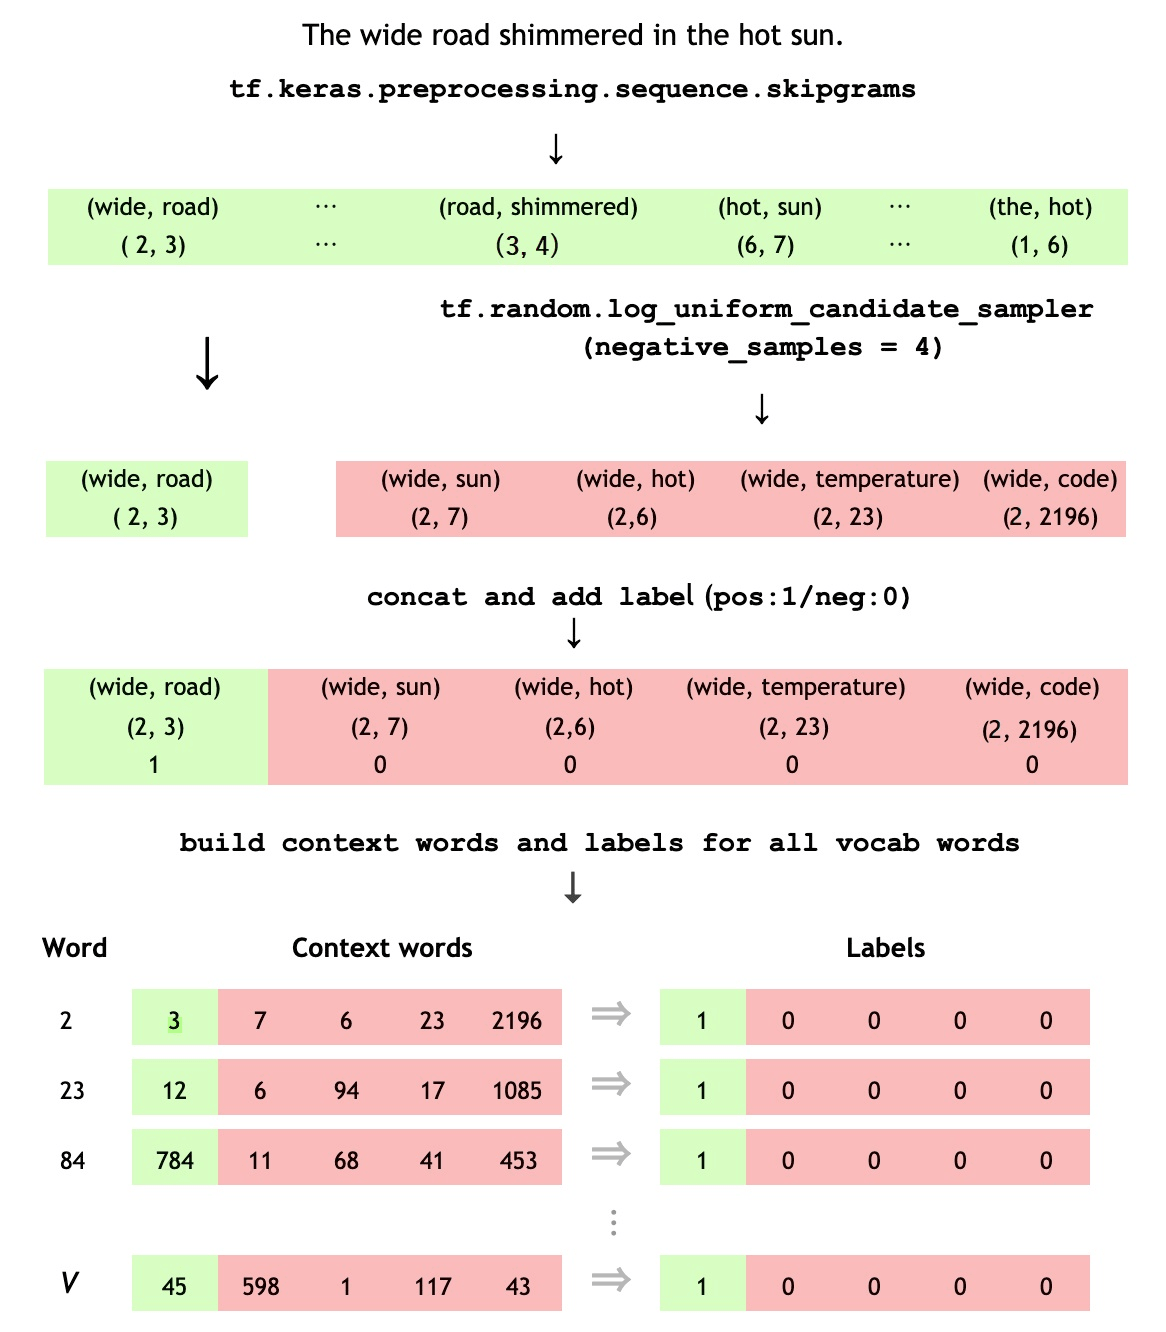

Observe que las palabras `temperature` y `code` no forman parte de la oración de entrada. Pertenecen al vocabulario como algunos otros índices utilizados en el diagrama anterior.

## 3. Compilar todos los pasos en una funcion

### 3.1 Tabla de muestreo de salto de gramo

Un conjunto de datos grande significa un vocabulario más grande con una mayor cantidad de palabras más frecuentes, como palabras vacías. Los ejemplos de entrenamiento obtenidos a partir de muestras de palabras comunes ( `the` , `is` , `on` ) no agregan mucha información útil para que el modelo aprenda. [Mikolov et al.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) sugiera el submuestreo de palabras frecuentes como una práctica útil para mejorar la calidad de incrustación.

La función [`tf.keras.preprocessing.sequence.skipgrams`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/skipgrams?hl=es-419) acepta un argumento de tabla de muestreo para codificar las probabilidades de muestrear cualquier token. Puede usar [`tf.keras.preprocessing.sequence.make_sampling_table`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/make_sampling_table?hl=es-419) para generar una tabla de muestreo probabilístico basada en el rango de frecuencia de palabras y pasarla a la función `skipgrams` . Inspeccione las probabilidades de muestreo para un `vocab_size` de 10.

In [24]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size = 10)
print(sampling_table)

[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558 ]


`sampling_table[i]` denota la probabilidad de muestrear la i-ésima palabra más común en un conjunto de datos. La función asume una [distribución de Zipf](https://en.wikipedia.org/wiki/Zipf%27s_law) de las frecuencias de palabras para el muestreo.

**Punto clave: El tf.random.log_uniform_candidate_sampler ya asume que la frecuencia del vocabulario sigue una distribución log-uniforme (Zipf). El uso de este muestreo ponderado de distribución también ayuda a aproximar la pérdida de estimación de contraste de ruido (NCE) con funciones de pérdida más simples para entrenar un objetivo de muestreo negativo.**

### 3.2 Generar datos de entrenamiento

Compile todos los pasos descritos anteriormente en una función que se pueda llamar en una lista de oraciones vectorizadas obtenidas de cualquier conjunto de datos de texto. Tenga en cuenta que la tabla de muestreo se construye antes de muestrear pares de palabras de salto de gramo. Utilizará esta función en las secciones posteriores.

In [25]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.

# * Genera pares de skip-gram con muestreo negativo para una lista de secuencias
# * (oraciones codificadas en int) basadas en el tamaño de la ventana, el número de muestras negativas
# * y tamaño del vocabulario.
def generate_training_data(sequences, window_size, num_ns,vocab_size, seed):

    # Elements of each training example are appended to these lists.
    # * Los elementos de cada ejemplo de entrenamiento se agregan a estas listas.
    targets, contexts, labels = [], [], []

    # Build the sampling table for vocab_size tokens.
    # * Construye la tabla de muestreo para tokens de vocab_size.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    # Iterate over all sequences (sentences) in dataset.
    # * Itera sobre todas las secuencias (oraciones) en el conjunto de datos.
    for sequence in tqdm.tqdm(sequences):

        # Generate positive skip-gram pairs for a sequence (sentence).
        # * Genera pares de skip-gram positivos para una secuencia (oración).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences,
            vocabulary_size = vocab_size,
            sampling_table  = sampling_table,
            window_size     = window_size,
            negative_samples= 0
        )

        # Iterate over each positive skip-gram pair to produce training examples
        # with positive context word and negative samples.
        # * Itera sobre cada par de skip-gram positivo para producir ejemplos de entrenamiento
        # * con palabra de contexto positiva y muestras negativas.
        for target_word, context_word in positive_skip_grams:

            context_class = tf.expand_dims(
            tf.constant([context_word],dtype = "int64"), 1)

            negative_sampling_canddates,_ ,_ = tf.random.log_uniform_candidate_sampler(
                true_classes = context_class,
                num_true     = 1,
                num_sampled  = num_ns,
                unique       = True,
                range_max    = vocab_size,
                seed         = SEED,
                name         = "negative_sampling"
            )

            # Build context and label vectors (for one target word)
            # * Construye vectores de contexto y etiquetas (para una palabra objetivo)
            negative_sampling_candidates = tf.expand_dims(
                negative_sampling_canddates, 1)

            context = tf.concat([context_class, negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns,dtype = "int64")

            # Append each element from the training example to global lists.
            # * Agrega cada elemento del ejemplo de entrenamiento a las listas globales.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

## 4. Preparar datos de entrenamiento para word2vec

Con una comprensión de cómo trabajar con una oración para un modelo word2vec basado en muestreo negativo skip-gram, ¡puede proceder a generar ejemplos de entrenamiento a partir de una lista más grande de oraciones!

### 4.1 Descargar corpus de texto

Utilizará un archivo de texto de la escritura de Shakespeare para este tutorial. Cambie la siguiente línea para ejecutar este código en sus propios datos.

In [26]:
path_to_file = tf.keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 1s 1us/step


Lea el texto del archivo e imprima las primeras líneas:

In [27]:
with open(path_to_file) as f:
    lines = f.read().splitlines()

for line in lines[:20]:
    print(line)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.


Use las líneas no vacías para construir un objeto [`tf.data.TextLineDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset?hl=es-419) para los siguientes pasos:

In [29]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

### 4.2 Vectorizar oraciones del corpus

Puede usar la capa `TextVectorization` para vectorizar oraciones del corpus. Obtenga más información sobre el uso de esta capa en este tutorial de [clasificación de texto](https://www.tensorflow.org/tutorials/keras/text_classification?hl=es-419) . Observe en las primeras oraciones anteriores que el texto debe estar en un caso y se debe eliminar la puntuación. Para hacer esto, defina una `custom_standardization function` que se pueda usar en la capa TextVector